In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import warnings
warnings.filterwarnings('ignore')
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
#https://drive.google.com/file/d/1sCCEmEKjHyH0iaoNwLYYDI5QyW9zeVlL/view?usp=sharing
fileDownloaded = drive.CreateFile({"id":"1sCCEmEKjHyH0iaoNwLYYDI5QyW9zeVlL"})

fileDownloaded.GetContentFile("data.pkl")

In [ ]:

import pickle
import pandas as pd
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import matplotlib.pyplot as plt
from gensim.models import Phrases
from gensim.models.phrases import Phraser
import numpy as np
#!pip install kneed
from kneed import KneeLocator
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
dataset = pickle.load(open("data.pkl", "rb"))
#dataset.head(5)

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')
sw = stopwords.words('english')
sw.extend(['many', 'good', 'like', 'liked', 'well', 'great', 'get', 'also', 'really', 'very', 'put'])
 
# Remove custom stopwords
def rem_sw(var):
    my_test = [word for word in var.split() if word not in sw]
    my_test = ' '.join(my_test)
    return my_test

# Remove words less than 3 characters
def length_fun(var):
    tmp_txt = [word for word in var.split() if len(word) > 2]
    tmp_txt = ' '.join(tmp_txt)
    return tmp_txt

# Stem text
def stem_fun(var):
    from nltk.stem.porter import PorterStemmer
    stemmer = PorterStemmer()
    tmp_txt = [stemmer.stem(word) for word in var.split()]
    tmp_txt = ' '.join(tmp_txt)
    return tmp_txt

# Lemmatize the text
nltk.download('punkt')
nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize_fun(var):
    tmp_txt = [wordnet_lemmatizer.lemmatize(word) for word in var.split()]
    tmp_txt = ' '.join(tmp_txt)
    return tmp_txt

dataset['review_body_clean_2'] = dataset['review_body_clean'].apply(rem_sw).apply(length_fun).apply(lemmatize_fun).apply(rem_sw)
#.str.split() 
dataset.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,review_category,review_body_clean,review_body_clean_2
0,US,33605939,RGYFDX8QXKEIR,B007KO2MLO,328837464,Big Maria,Digital_Ebook_Purchase,4,0,0,0,0,Quirky,Elmore Leonard meets the cast of Sierra Madre....,2013-09-09,positive,elmore leonard meets the cast of sierra madre ...,elmore leonard meet cast sierra madre quirky r...
1,US,34058393,R13CBGTMNV9R8Z,B005FLODDE,764276359,The Woman Who Wasn't There: The True Story of ...,Digital_Ebook_Purchase,4,1,2,0,1,The Woman Who Wasn't There,This book was very interesting. It is a true s...,2013-09-09,positive,this book was very interesting it is a true st...,book interesting true story woman perpetrated ...
2,US,39601147,R7DRFHC0F71O0,B00EA3L35O,535606445,Mary had A Sleepy Sheep,Digital_Ebook_Purchase,5,0,0,0,0,This Sleepy Sheep rocks!,I had the opportunity to review Mary had a Sle...,2013-09-09,positive,i had the opportunity to review mary had a sle...,opportunity review mary sleepy sheep julia dwe...
3,US,17351407,R27LUKEXU3KBXQ,B00BL3JV50,240053004,Starstruck,Digital_Ebook_Purchase,5,1,1,0,1,Steamy and suspenseful!!!!!,What a great read! I really couldn't put this...,2013-09-09,positive,what a great read i really couldn t put this b...,read book suspenseful twist steamy love story ...
4,US,10463387,R1VXTPUYMNU687,B00CXU7U80,931529805,The Complete Conan Saga,Digital_Ebook_Purchase,5,1,2,0,0,Barbarians,Barbarians need love too ! Short stories work...,2013-09-09,positive,barbarians need love too short stories work we...,barbarian need love short story work ebooks te...


In [ ]:
test = dataset.sort_values(['helpful_votes'], ascending=[False])
test.head()
test.helpful_votes.describe()

count    51017.000000
mean         0.992257
std          4.149251
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        259.000000
Name: helpful_votes, dtype: float64

In [ ]:
review_df = dataset[['review_body_clean_2','star_rating']]
def review_sentiment(df):
    if df['star_rating'] >= 4:
        return 'Positive'
    elif df['star_rating'] == 3:
        return 'Neutral'
    elif df['star_rating'] <= 2:
        return 'Negative'
review_df['review_category'] = review_df.apply(review_sentiment, axis = 1)
review_df.head(10)

,review_body_clean_2,star_rating,review_category
0,elmore leonard meet cast sierra madre quirky r...,4,Positive
1,book interesting true story woman perpetrated ...,4,Positive
2,opportunity review mary sleepy sheep julia dwe...,5,Positive
3,read book suspenseful twist steamy love story ...,5,Positive
4,barbarian need love short story work ebooks te...,5,Positive
5,okay obviously read beginning book would confu...,3,Neutral
6,interesting kept reading read one day much any...,5,Positive
7,enjoyed book author ready read next one thanks...,5,Positive
8,book felt got know character read,5,Positive
9,reading callum stella story bit watching tenni...,4,Positive


In [ ]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [ ]:

analyzer = SentimentIntensityAnalyzer()
# function to calculate vader sentiment
def varder_sentiment_scores(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']
review_df['Vader Sentiment'] = review_df['review_body_clean_2'].apply(varder_sentiment_scores)
def vader_analysis(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound <= -0.5 :
        return 'Negative'
    else:
        return 'Neutral'
review_df['Vader Analysis'] = review_df['Vader Sentiment'].apply(vader_analysis)

review_df.head(10)

,review_body_clean_2,star_rating,review_category,Vader Sentiment,Vader Analysis
0,elmore leonard meet cast sierra madre quirky r...,4,Positive,0.1027,Neutral
1,book interesting true story woman perpetrated ...,4,Positive,0.2263,Neutral
2,opportunity review mary sleepy sheep julia dwe...,5,Positive,0.5267,Positive
3,read book suspenseful twist steamy love story ...,5,Positive,0.7506,Positive
4,barbarian need love short story work ebooks te...,5,Positive,0.6369,Positive
5,okay obviously read beginning book would confu...,3,Neutral,0.7003,Positive
6,interesting kept reading read one day much any...,5,Positive,0.4019,Neutral
7,enjoyed book author ready read next one thanks...,5,Positive,0.8271,Positive
8,book felt got know character read,5,Positive,0.0000,Neutral
9,reading callum stella story bit watching tenni...,4,Positive,0.9118,Positive


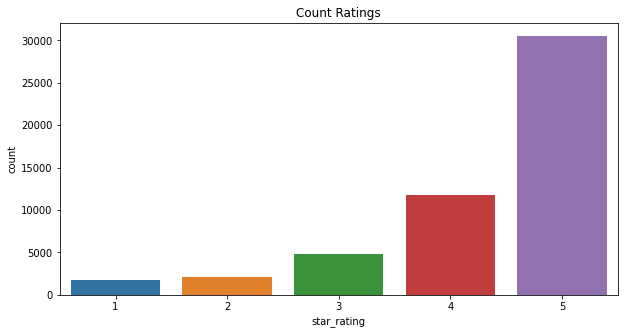

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(review_df['star_rating'])
plt.title('Count Ratings')
plt.show()

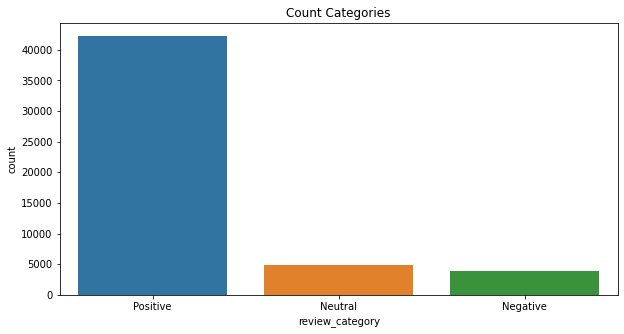

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(review_df['review_category'])
plt.title('Count Categories')
plt.show()

In [ ]:
#devide into positive, neutral and negative
review_pos = review_df[review_df["review_category"]=='Positive'].dropna()
review_neu = review_df[review_df["review_category"]=='Neutral'].dropna()
review_neg = review_df[review_df["review_category"]=='Negative'].dropna()

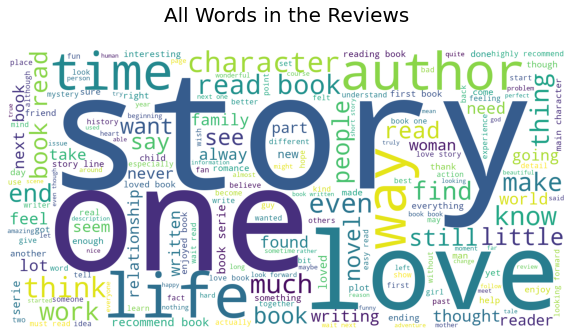

In [ ]:
#Exploratory Data Analysis
#We will start be veryfing what are the most common words used in the text reviews using a word cloud. 
rt = review_df['review_body_clean_2']
wordcloud = WordCloud(background_color='white',
                      width=1600,
                      height=800
                     ).generate(" ".join(rt))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.title('All Words in the Reviews\n',size=20)
plt.axis('off')
plt.show()

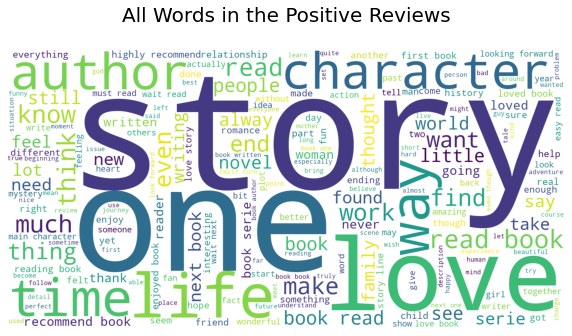

In [ ]:
rt = review_pos['review_body_clean_2']
wordcloud = WordCloud(background_color='white',
                      width=1600,
                      height=800
                     ).generate(" ".join(rt))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.title('All Words in the Positive Reviews\n',size=20)
plt.axis('off')
plt.show()

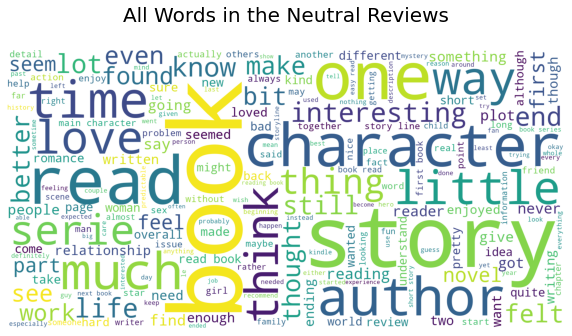

In [ ]:
#neutral
rt = review_neu['review_body_clean_2']
wordcloud = WordCloud(background_color='white',
                      width=1600,
                      height=800
                     ).generate(" ".join(rt))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.title('All Words in the Neutral Reviews\n',size=20)
plt.axis('off')
plt.show()

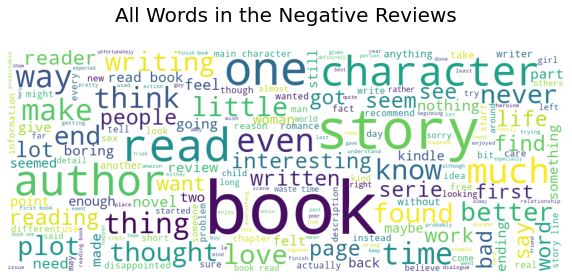

In [ ]:
#negative
rt = review_neg['review_body_clean_2']
wordcloud = WordCloud(background_color='white',
                      width=1000,
                      height=400
                     ).generate(" ".join(rt))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.title('All Words in the Negative Reviews\n',size=20)
plt.axis('off')
plt.show()

In [ ]:
sentiment = {1: 0,
            2: 0,
            3: 1,
            4: 2,
            5: 2}

review_df["sentiment"] = review_df["star_rating"].map(sentiment)
review_df.head()

,review_body_clean_2,star_rating,review_category,Vader Sentiment,Vader Analysis,sentiment
0,elmore leonard meet cast sierra madre quirky r...,4,Positive,0.1027,Neutral,2
1,book interesting true story woman perpetrated ...,4,Positive,0.2263,Neutral,2
2,opportunity review mary sleepy sheep julia dwe...,5,Positive,0.5267,Positive,2
3,read book suspenseful twist steamy love story ...,5,Positive,0.7506,Positive,2
4,barbarian need love short story work ebooks te...,5,Positive,0.6369,Positive,2


In [ ]:
len(review_df[review_df["sentiment"]==0]),len(review_df[review_df["sentiment"]==1]),len(review_df[review_df["sentiment"]==2])

(3935, 4830, 42252)

In [ ]:
review_df.head()

,review_body_clean_2,star_rating,review_category,Vader Sentiment,Vader Analysis,sentiment
0,elmore leonard meet cast sierra madre quirky r...,4,Positive,0.1027,Neutral,2
1,book interesting true story woman perpetrated ...,4,Positive,0.2263,Neutral,2
2,opportunity review mary sleepy sheep julia dwe...,5,Positive,0.5267,Positive,2
3,read book suspenseful twist steamy love story ...,5,Positive,0.7506,Positive,2
4,barbarian need love short story work ebooks te...,5,Positive,0.6369,Positive,2


In [ ]:
# building tfidf matrix to train models 
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer =TfidfVectorizer(max_df=0.9)
text = vectorizer.fit_transform(review_df["review_body_clean_2"])

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(text, review_df["sentiment"], test_size=0.3, random_state=1)

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=1)
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
y_pred_tr = classifier.predict(x_train)
print('Test accuracy', sum(y_test == y_pred)/len(y_test))
print('Train accuracy', sum(y_train == y_pred_tr)/len(y_train))

In [ ]:
print('Test accuracy', sum(y_test == y_pred)/len(y_test))
print('Train accuracy', sum(y_train == y_pred_tr)/len(y_train))

In [ ]:
from sklearn.metrics import classification_report
print("Classification Report(Train)")
print(classification_report(y_train, y_pred_tr))
print("Classification Report(Test)")
print(classification_report(y_test, y_pred))


Very low F1 score for the test data set for the undersampled data sets. We'll try with the Randm Forest algorithm again.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
y_pred_tr = classifier.predict(x_train)
print('Test accuracy', sum(y_test == y_pred)/len(y_test))
print('Train accuracy', sum(y_train == y_pred_tr)/len(y_train))

In [ ]:
print("Classification Report(Train)")
print(classification_report(y_train, y_pred_tr))
print("Classification Report(Test)")
print(classification_report(y_test, y_pred))

In [ ]:

from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier()
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
y_pred_tr = classifier.predict(x_train)
print('Test accuracy', sum(y_test == y_pred)/len(y_test))
print('Train accuracy', sum(y_train == y_pred_tr)/len(y_train))

In [ ]:
print("Classification Report(Train)")
print(classification_report(y_train, y_pred_tr))
print("Classification Report(Test)")
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.naive_bayes import BernoulliNB
classifier = BernoulliNB()
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
y_pred_tr = classifier.predict(x_train)
print('Test accuracy', sum(y_test == y_pred)/len(y_test))
print('Train accuracy', sum(y_train == y_pred_tr)/len(y_train))

In [ ]:
print("Classification Report(Train)")
print(classification_report(y_train, y_pred_tr))
print("Classification Report(Test)")
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.svm import SVC
classifier = SVC()
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
y_pred_tr = classifier.predict(x_train)
print('Test accuracy', sum(y_test == y_pred)/len(y_test))
print('Train accuracy', sum(y_train == y_pred_tr)/len(y_train))

In [ ]:
print("Classification Report(Train)")
print(classification_report(y_train, y_pred_tr))
print("Classification Report(Test)")
print(classification_report(y_test, y_pred))